# Import Libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Obtain Data

Read csv file with Temperature data into Pandas and drop non-NYC temperature columns

In [29]:
df = pd.read_csv('Data/temperature.csv')
df = df[['datetime','New York']]
df.columns = ['Period', 'NYC Temperature']
df.head()

,Period,NYC Temperature
0,10/1/12 12:00,NaN
1,10/1/12 13:00,288.220000
2,10/1/12 14:00,288.247676
3,10/1/12 15:00,288.326940
4,10/1/12 16:00,288.406203


# Scrub Data

Use df.info() to determine what dataset scrubbing needed

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 2 columns):
Period             45253 non-null object
NYC Temperature    44460 non-null float64
dtypes: float64(1), object(1)
memory usage: 707.2+ KB


Change Period column data type to datetime

In [31]:
df['Period'] = pd.to_datetime(df['Period'], dayfirst=False)
df.head()

,Period,NYC Temperature
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,288.220000
2,2012-10-01 14:00:00,288.247676
3,2012-10-01 15:00:00,288.326940
4,2012-10-01 16:00:00,288.406203


View missing time series values

In [32]:
df[df['NYC Temperature'].isna()]

,Period,NYC Temperature
0,2012-10-01 12:00:00,NaN
44461,2017-10-28 01:00:00,NaN
44462,2017-10-28 02:00:00,NaN
44463,2017-10-28 03:00:00,NaN
44464,2017-10-28 04:00:00,NaN
...,...,...
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN


Remove rows with missing temperature values at start and end of time series

In [33]:
df = df.loc[1:44460, :]
df

,Period,NYC Temperature
1,2012-10-01 13:00:00,288.220000
2,2012-10-01 14:00:00,288.247676
3,2012-10-01 15:00:00,288.326940
4,2012-10-01 16:00:00,288.406203
5,2012-10-01 17:00:00,288.485467
...,...,...
44456,2017-10-27 20:00:00,289.980000
44457,2017-10-27 21:00:00,289.480000
44458,2017-10-27 22:00:00,287.920000
44459,2017-10-27 23:00:00,285.830000


Plot time series dataset to look for outliers

[Text(0, 0, '2012-10-01T13:00:00.000000000'),
 Text(0, 0, '2012-10-01T14:00:00.000000000'),
 Text(0, 0, '2012-10-01T15:00:00.000000000'),
 Text(0, 0, '2012-10-01T16:00:00.000000000'),
 Text(0, 0, '2012-10-01T17:00:00.000000000'),
 Text(0, 0, '2012-10-01T18:00:00.000000000'),
 Text(0, 0, '2012-10-01T19:00:00.000000000')]

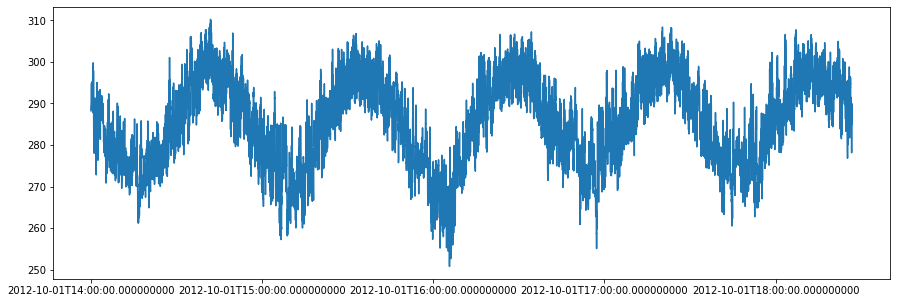

In [34]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['NYC Temperature'].values)
ax.set_xticklabels(df['Period'].values)

Use df.info() to confirm dataset now scrubbed

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44460 entries, 1 to 44460
Data columns (total 2 columns):
Period             44460 non-null datetime64[ns]
NYC Temperature    44460 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 694.8 KB


# Explore data

Calculate the descriptive statistics for temperature

In [36]:
df['NYC Temperature'].describe()

count    44460.000000
mean       285.400406
std         10.220932
min        250.774000
25%        277.370000
50%        285.870000
75%        293.760000
max        310.240000
Name: NYC Temperature, dtype: float64

Plot the time series dataset

Text(0.5, 1.0, 'NYC Temperature by Hour')

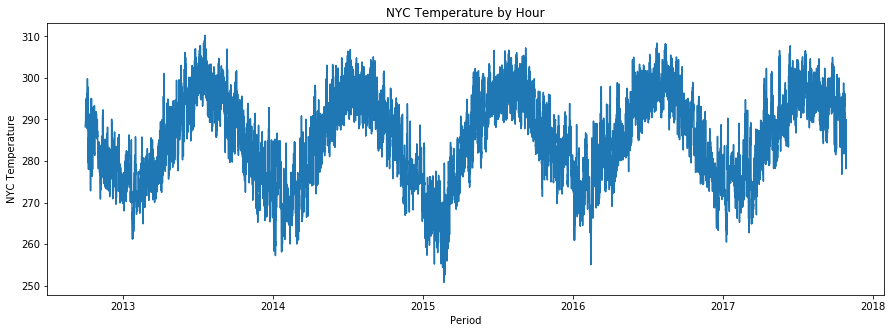

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Period', y='NYC Temperature', data=df, ax=ax)
ax.set_title('NYC Temperature by Hour')

Create time series df with month, day and year columns

In [38]:
eda_df = df.copy()
eda_df['Year'] = pd.DatetimeIndex(df['Period']).year
eda_df['Month'] = pd.DatetimeIndex(df['Period']).month
eda_df['Day'] = pd.DatetimeIndex(df['Period']).day
eda_df['Day of Year'] = pd.DatetimeIndex(df['Period']).dayofyear
eda_df['Hour'] = pd.DatetimeIndex(df['Period']).hour
eda_df.head()

,Period,NYC Temperature,Year,Month,Day,Day of Year,Hour
1,2012-10-01 13:00:00,288.220000,2012,10,1,275,13
2,2012-10-01 14:00:00,288.247676,2012,10,1,275,14
3,2012-10-01 15:00:00,288.326940,2012,10,1,275,15
4,2012-10-01 16:00:00,288.406203,2012,10,1,275,16
5,2012-10-01 17:00:00,288.485467,2012,10,1,275,17


Plot yearly trend in time series data

Text(0.5, 1.0, 'Average NYC Temperature by Year')

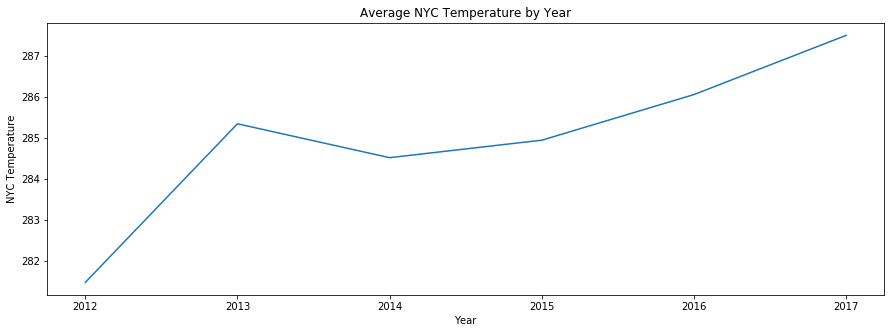

In [39]:
annual_df = eda_df.groupby('Year').mean()
annual_df.drop(index=[2012, 2017])
annual_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Year', y='NYC Temperature', data=annual_df, ax=ax)
ax.set_title('Average NYC Temperature by Year')

Plot Monthly trend in time series data

Text(0.5, 1.0, 'Average NYC Temperature by Month')

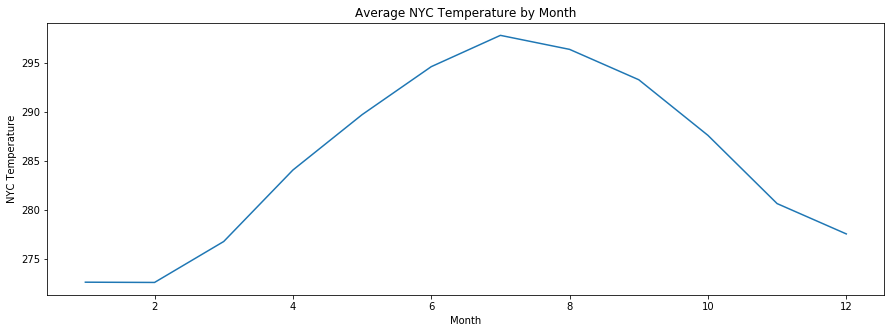

In [40]:
monthly_df = eda_df.groupby('Month').mean()
monthly_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Month', y='NYC Temperature', data=monthly_df, ax=ax)
ax.set_title('Average NYC Temperature by Month')

Plot daily trend in time series data

Text(0.5, 1.0, 'Average NYC Temperature by Day of Year')

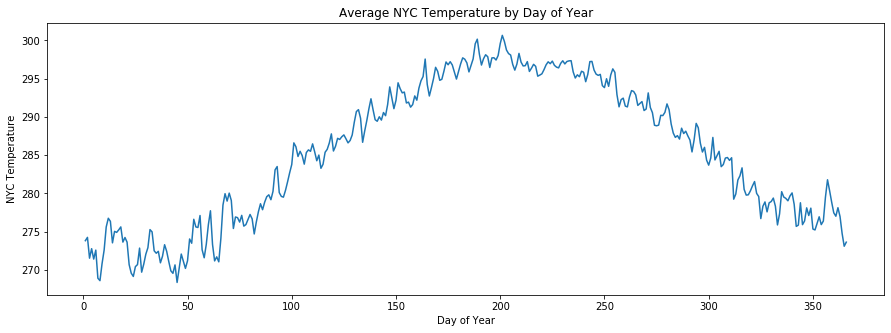

In [41]:
day_df = eda_df.groupby('Day of Year').mean()
day_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Day of Year', y='NYC Temperature', data=day_df, ax=ax)
ax.set_title('Average NYC Temperature by Day of Year')

Plot hourly trend in time series data

Text(0.5, 1.0, 'Average NYC Temperature by Hour')

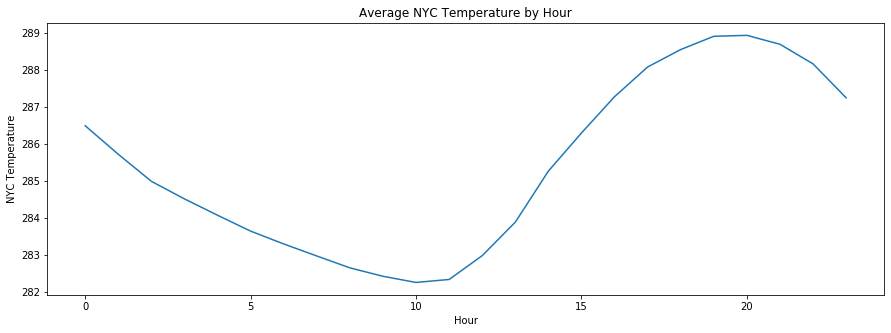

In [42]:
hourly_df = eda_df.groupby('Hour').mean()
hourly_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Hour', y='NYC Temperature', data=hourly_df, ax=ax)
ax.set_title('Average NYC Temperature by Hour')

# Model Data

Difference time series data

In [46]:
df['Differenced Temperature'] = df[['NYC Temperature']].diff(periods=1)
df.head()

,Period,NYC Temperature,Differenced Temperature
1,2012-10-01 13:00:00,288.220000,NaN
2,2012-10-01 14:00:00,288.247676,0.027676
3,2012-10-01 15:00:00,288.326940,0.079263
4,2012-10-01 16:00:00,288.406203,0.079264
5,2012-10-01 17:00:00,288.485467,0.079263


Plot differenced time series data

Text(0.5, 1.0, 'Differenced NYC Temperature by Hour')

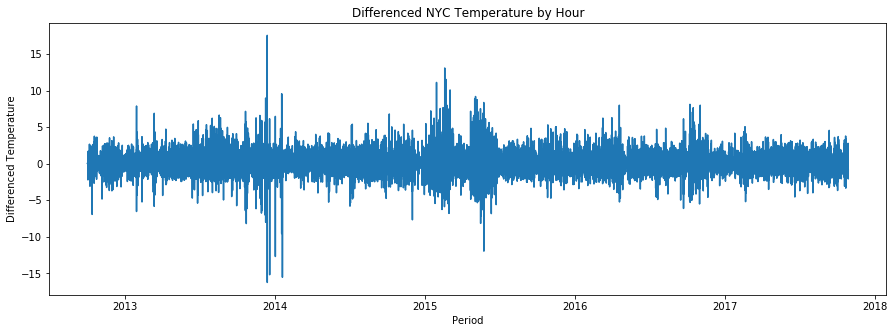

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='Period', y='Differenced Temperature', data=df, ax=ax)
ax.set_title('Differenced NYC Temperature by Hour')

Run Dickey-Fuller test on differenced time series data

In [52]:
adfuller(df['Differenced Temperature'][1:])

(-34.7610041399221,
 0.0,
 56,
 44402,
 {'1%': -3.4304972834126013,
  '5%': -2.8616050960627084,
  '10%': -2.566804648512745},
 109095.95170199437)

Plot time series acf

Text(0, 0.5, 'Correlation')

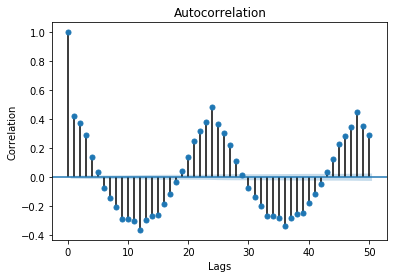

In [54]:
fig, ax = plt.subplots()
plot_acf(df['Differenced Temperature'][1:], alpha=.05, lags = 50, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Plot time series pacf

Text(0, 0.5, 'Correlation')

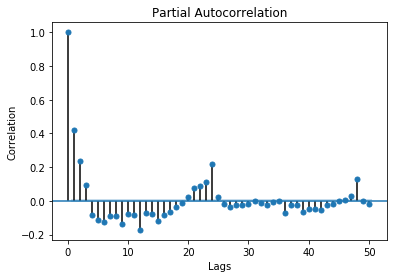

In [55]:
fig, ax = plt.subplots()
plot_pacf(df['Differenced Temperature'][1:], alpha=.05, lags = 50, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Perform train test split

In [59]:
train_series = df['NYC Temperature'].values[:-8760]
val_series = df['NYC Temperature'].values[-8760:]

Build baseline model

In [64]:
train_predictions = train_series[0:-1]
train_actuals = train_series[1:]
val_predictions = val_series[0:-1]
val_actuals = val_series[1:]
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_actuals, val_predictions)))
print('Validation MAE:', mean_absolute_error(val_actuals, val_predictions))

Train RMSE: 1.1093867794007684
Train MAE: 0.7303019040869493
Validation RMSE: 0.9325088278585365
Validation MAE: 0.6676708094303002


Build SARIMA model

In [ ]:
sarima = SARIMAX(train_series, order = (3,1,3), seasonal_order = (3,1,3,24))
sarima_model = sarima.fit()
print(sarima_model.summary())
print(sarima_model.params)

Evaluate SARIMA model

In [ ]:
val_pred_sarima = sarima_model.forecast(steps=8760)
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_sarima)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_sarima))